In [1]:
# pip install --upgrade pip

In [2]:
# %pip install levenshtein
# %pip install fuzzywuzzy

In [3]:
import pandas as pd
import numpy as np
from itertools import combinations
from difflib import SequenceMatcher

def row_to_sequence(row):
    """Convert a row (excluding first col ID) into a tuple of tokens, dropping NaNs."""
    return tuple([x for x in row[1:] if pd.notna(x)])

def levenshtein_tokens(a, b):
    """
    Levenshtein edit distance between two sequences of tokens (lists/tuples).
    Operations: insert, delete, substitute; all cost 1.
    """
    len_a, len_b = len(a), len(b)
    if len_a == 0: return len_b
    if len_b == 0: return len_a

    # Use two rolling rows for O(min(len_a,len_b)) memory
    if len_b > len_a:
        a, b = b, a
        len_a, len_b = len_b, len_a

    prev = list(range(len_b + 1))
    curr = [0] * (len_b + 1)

    for i in range(1, len_a + 1):
        curr[0] = i
        ai = a[i - 1]
        for j in range(1, len_b + 1):
            cost = 0 if ai == b[j - 1] else 1
            curr[j] = min(
                prev[j] + 1,       # deletion
                curr[j - 1] + 1,   # insertion
                prev[j - 1] + cost # substitution
            )
        prev, curr = curr, prev
    return prev[-1]

def sequence_similarity_ratio(a_seq, b_seq):
    """
    Fuzzy-ish similarity in [0,1] via difflib on a pipe-joined string version of the sequence.
    Converts to a distance = 1 - ratio.
    """
    a_str = "|".join(map(str, a_seq))
    b_str = "|".join(map(str, b_seq))
    return 1.0 - SequenceMatcher(None, a_str, b_str).ratio()

def distance_matrix_from_df(
    df: pd.DataFrame,
    method: str = "levenshtein",   # 'levenshtein' or 'fuzzy'
    normalize: bool = True         # normalize Levenshtein by max(len(a), len(b))
) -> pd.DataFrame:
    """
    Build an NxN distance matrix where N = number of rows.
    Assumes first column is the row identifier, remaining columns are positions in the action sequence.
    """
    if df.shape[1] < 2:
        raise ValueError("DataFrame must have at least 2 columns: ID + sequence columns.")

    ids = df.iloc[:, 0].astype(str).tolist()
    seqs = [row_to_sequence(row) for _, row in df.iterrows()]

    n = len(ids)
    D = np.zeros((n, n), dtype=float)

    for i, j in combinations(range(n), 2):
        a, b = seqs[i], seqs[j]
        if method == "levenshtein":
            dist = levenshtein_tokens(a, b)
            if normalize:
                denom = max(len(a), len(b))
                dist = (dist / denom) if denom > 0 else 0.0
        elif method == "fuzzy":
            dist = sequence_similarity_ratio(a, b)  # already in [0,1]
        else:
            raise ValueError("Unknown method. Use 'levenshtein' or 'fuzzy'.")

        D[i, j] = dist
        D[j, i] = dist

    return pd.DataFrame(D, index=ids, columns=ids)

In [4]:
#ALL participants
df = pd.read_csv('/Users/jennaolsen/Downloads/participant_move_sequences.csv')
 
# Levenshtein distance on token sequences, normalized to [0,1]
D_lev = distance_matrix_from_df(df, method="levenshtein", normalize=True)
# print("Levenshtein (normalized) distance matrix:\n", D_lev, "\n")

# Fuzzy (difflib) distance on stringified sequences, in [0,1]
D_fuzzy = distance_matrix_from_df(df, method="fuzzy", normalize=True)
# print("Fuzzy (difflib) distance matrix:\n", D_fuzzy)

D_fuzzy.to_csv('/Users/jennaolsen/Downloads/fuzzy_Moves.csv')
D_lev.to_csv('/Users/jennaolsen/Downloads/Sneaky_Lev_Moves.csv')

In [5]:
# #3+ moves participants
# df3 = pd.read_csv('/Users/jennaolsen/Downloads/participant_move_sequences_3plus_forPython.csv')
 
# # Levenshtein distance on token sequences, normalized to [0,1]
# D_lev3 = distance_matrix_from_df(df3, method="levenshtein", normalize=True)
# # print("Levenshtein (normalized) distance matrix:\n", D_lev, "\n")

# # Fuzzy (difflib) distance on stringified sequences, in [0,1]
# D_fuzzy3 = distance_matrix_from_df(df3, method="fuzzy", normalize=True)
# # print("Fuzzy (difflib) distance matrix:\n", D_fuzzy)

# D_fuzzy3.to_csv('/Users/jennaolsen/Downloads/fuzzy_3_Moves.csv')
# D_lev3.to_csv('/Users/jennaolsen/Downloads/Sneaky_Lev_3_Moves.csv')

/Applications/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2313 (\N{DEVANAGARI LETTER U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Applications/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/Applications/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Applications/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN VIRAMA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Applications/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from current font.
  fig.canvas.print_fig

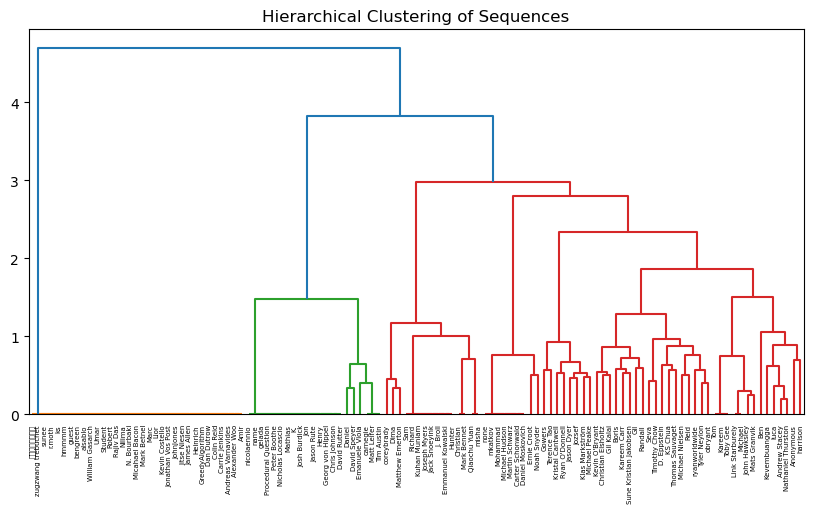

Alexander Woo          1
Amir                   1
Andreas Varnavides     1
Andrew Stacey         33
Anonymous             35
                      ..
r.moth                 1
ryanworldwide         30
sunee                  1
zugzwang trebuchet     1
उन्मुक्त               1
Length: 118, dtype: int32


In [6]:
# Clustering based on Levenshtein distance
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# Suppose D is your distance matrix from earlier
# Example: D = distance_matrix_from_df(df, method="levenshtein")

# Convert to condensed distance format (1D array) for SciPy
from scipy.spatial.distance import squareform
condensed_D = squareform(D_lev.values)

# Perform hierarchical clustering
Z = linkage(condensed_D, method="ward")  # methods: 'single', 'complete', 'average', 'ward'

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z, labels=D_lev.index.tolist(), leaf_rotation=90)
plt.title("Hierarchical Clustering of Sequences")
plt.show()

# Get flat clusters (cutting at distance threshold or #clusters)
clusters = fcluster(Z, t=0.5, criterion="distance")  # or criterion="maxclust"
cluster_assignments = pd.Series(clusters, index=D_lev.index)
print(cluster_assignments)

#This clustering (with average) compares to the clustering from Step 1 here https://docs.google.com/document/d/1UsZdXWOg65GhDDZl8NzieAcACzC5I05TBdGx816ShGU/edit?tab=t.pup0h8c4y7ol#heading=h.70a3t7z5ls5j
#There are some similar groupings - but also differences 